## Feature-Based Model Results (n_classes = 2)

### 1) Import + preprocessing

In [1]:
import pandas as pd
import numpy as np

import os
from os import listdir
from os.path import isfile, join
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

joblib_files_2 = [f for f in listdir(os.path.join('..','..','0_data','models','feature_based')) if isfile(join(os.path.join('..','..','0_data','models','feature_based'), f)) and 'joblib' in f and '_2_' in f]
joblib_files_5 = [f for f in listdir(os.path.join('..','..','0_data','models','feature_based')) if isfile(join(os.path.join('..','..','0_data','models','feature_based'), f)) and 'joblib' in f and '_5_' in f]

def get_df_from_joblib(joblib_file):

    params = joblib_file[0:-7].split('__')

    result = joblib.load(os.path.join('..','..','0_data','models','feature_based',joblib_file))

    if int(params[1])==2:
        metrics_values = np.array([list(result[j]['metrics'].values()) for j in range(5)])
        mean_metrics = list(np.mean(metrics_values, axis=0))
        std_metrics = list(np.std(metrics_values, axis=0))
        metrics_name = list(result[0]['metrics'].keys())
    if int(params[1])==5:
        metrics_values = np.array([list(result[j]['metrics'].values())[0:-2] for j in range(5)])
        mean_metrics = list(np.mean(metrics_values, axis=0))
        std_metrics = list(np.std(metrics_values, axis=0))
        metrics_name = list(result[0]['metrics'].keys())[0:-2]

    df_results = pd.DataFrame(
        [params + mean_metrics + std_metrics],
        columns=['model','nclasses','vectorizer_type','C','emoji','norm_type','vocab_size','ngram_range'] + ['mean_'+i for i in metrics_name] + ['std_'+i for i in metrics_name]
    )

    return df_results

results_2 = pd.concat([get_df_from_joblib(i) for i in tqdm(joblib_files_2)]).reset_index(drop=True)
results_5 = pd.concat([get_df_from_joblib(i) for i in tqdm(joblib_files_5)]).reset_index(drop=True)

results_2.C = results_2.C.astype(float)
results_5.C = results_5.C.astype(float)

100%|██████████| 828/828 [00:03<00:00, 220.98it/s]


### 2) Analyzing Results

#### Overview 

In [2]:
results_5.mean_accuracy_valid.describe()[['mean','50%','min','max']]

mean    0.580415
50%     0.576171
min     0.567737
max     0.594691
Name: mean_accuracy_valid, dtype: float64

#### Vectorizer: Count x TF-iDF

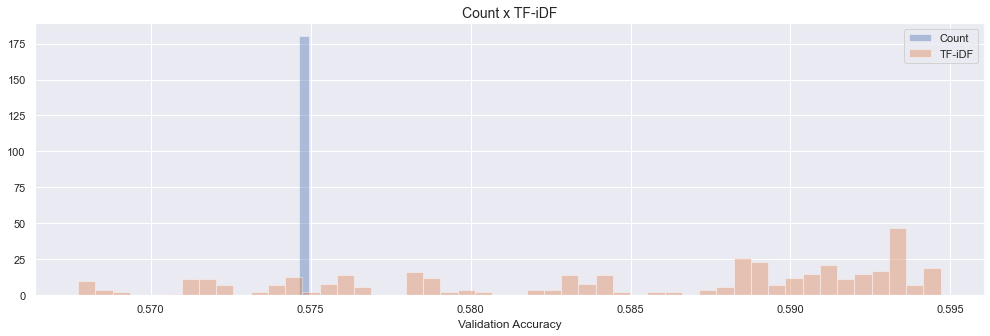

In [8]:
plt.figure(figsize=(17,5))
g0 = sns.distplot(results_5.mean_accuracy_valid[(results_5.vectorizer_type=='count') & (results_5.norm_type=='none')], kde=False, bins=1, label='Count')
g1 = sns.distplot(results_5.mean_accuracy_valid[results_5.vectorizer_type=='tfidf'], kde=False, bins=50, label='TF-iDF')

#g1.set_xlim(0.880,0.910)
g1.set_xlabel('Validation Accuracy')
g1.set_title('Count x TF-iDF', size=14)

plt.legend();

#### Emoji: With x Without

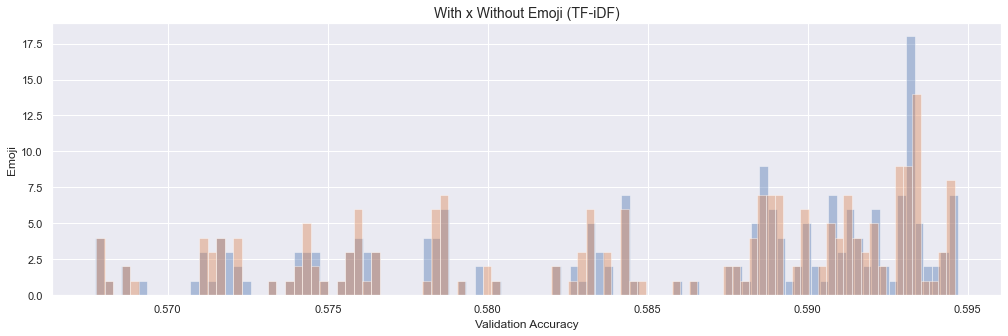

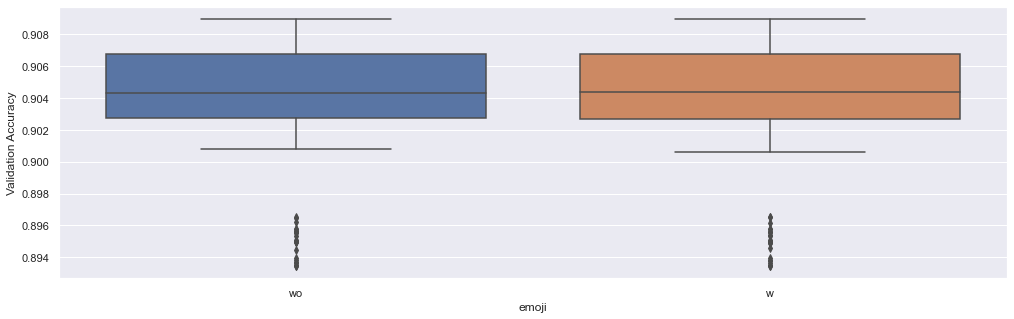

In [10]:
results_5_tdidf = results_5[results_5.vectorizer_type=='tfidf']

plt.figure(figsize=(17,5))
g0 = sns.distplot(results_5_tdidf.mean_accuracy_valid[results_5.emoji=='wo'], kde=False, bins=100, label='Without Emoji')
g1 = sns.distplot(results_5_tdidf.mean_accuracy_valid[results_5.emoji=='w'],  kde=False, bins=100, label='With Emoji')

g1.set_xlabel('Validation Accuracy')
g1.set_title('With x Without Emoji (TF-iDF)', size=14)

plt.figure(figsize=(17,5))
g0 = sns.boxplot(x='emoji', y='mean_accuracy_valid', data=results_2_tdidf)
g0.set_ylabel('Validation Accuracy')
g1.set_ylabel('Emoji');

#### Normalization: Stemming x Lemmatization x Without Normalization

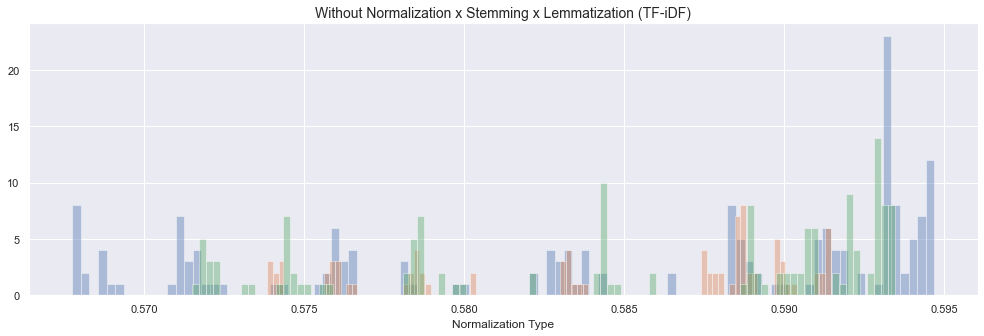

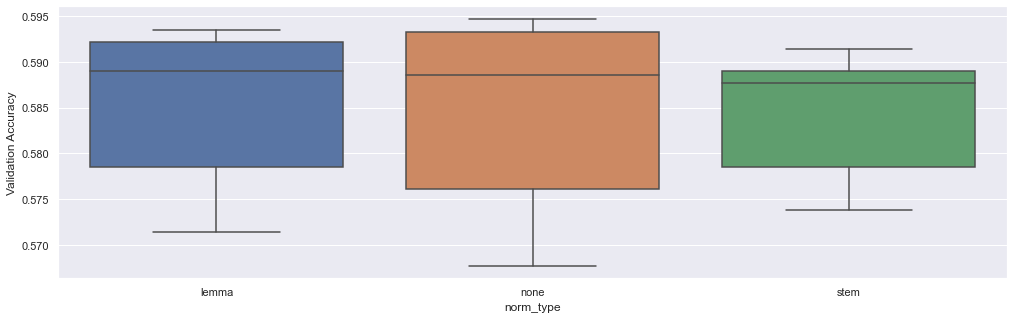

In [11]:
results_5_tdidf = results_5[results_5.vectorizer_type=='tfidf']

plt.figure(figsize=(17,5))
g0 = sns.distplot(results_5_tdidf.mean_accuracy_valid[results_5.norm_type=='none'], kde=False, bins=100, label='Without Normalization')
g1 = sns.distplot(results_5_tdidf.mean_accuracy_valid[results_5.norm_type=='stem'],  kde=False, bins=100, label='Stemming')
g1 = sns.distplot(results_5_tdidf.mean_accuracy_valid[results_5.norm_type=='lemma'],  kde=False, bins=100, label='Lemmatization')

g1.set_xlabel('Validation Accuracy')
g1.set_title('Without Normalization x Stemming x Lemmatization (TF-iDF)', size=14)

plt.figure(figsize=(17,5))
g0 = sns.boxplot(x='norm_type', y='mean_accuracy_valid', data=results_5_tdidf)
g0.set_ylabel('Validation Accuracy')
g1.set_xlabel('Normalization Type');

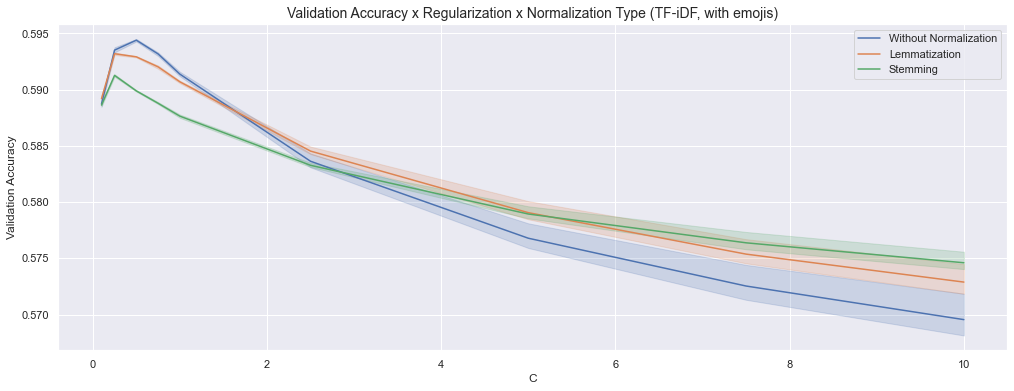

In [12]:
plt.figure(figsize=(17,6))
g0 = sns.lineplot(
    x='C', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='none') & (results_5_tdidf.emoji=='w')],
    label='Without Normalization'
)
g1 = sns.lineplot(
    x='C', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='lemma') & (results_5_tdidf.emoji=='w')],
    label='Lemmatization'
)
g2 = sns.lineplot(
    x='C', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='stem') & (results_5_tdidf.emoji=='w')],
    label='Stemming'
)
plt.legend()
g0.set_ylabel('Validation Accuracy')
g1.set_xlabel('C');

plt.legend()
g0.set_xlabel('C')
g0.set_ylabel('Validation Accuracy')
g0.set_title('Validation Accuracy x Regularization x Normalization Type (TF-iDF, with emojis)', size=14);

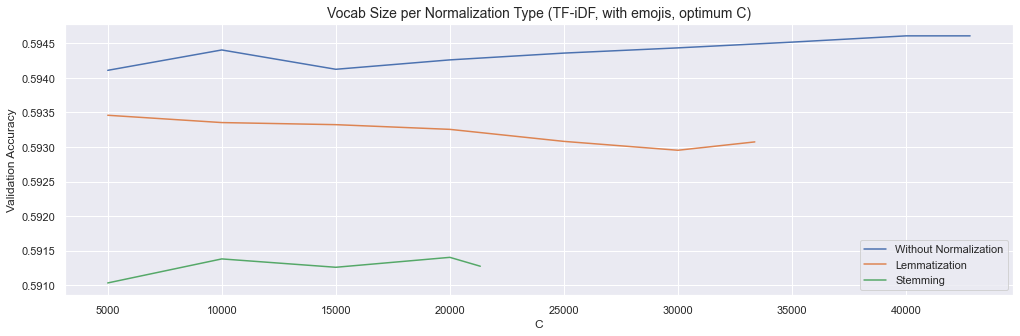

In [32]:
plt.figure(figsize=(17,5))
g0 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='none') & (results_5_tdidf.emoji=='w') & (results_5_tdidf.C==0.5)],
    label='Without Normalization'
)
g2 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='lemma') & (results_5_tdidf.emoji=='w') & (results_5_tdidf.C==0.25)],
    label='Lemmatization'
)
g1 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='stem') & (results_5_tdidf.emoji=='w') & (results_5_tdidf.C==0.25)],
    label='Stemming'
)

plt.legend()
g0.set_ylabel('Validation Accuracy')
g1.set_xlabel('C');

plt.legend()
g0.set_xlabel('C')
g0.set_ylabel('Validation Accuracy')
g0.set_title('Vocab Size per Normalization Type (TF-iDF, with emojis, optimum C)', size=14);

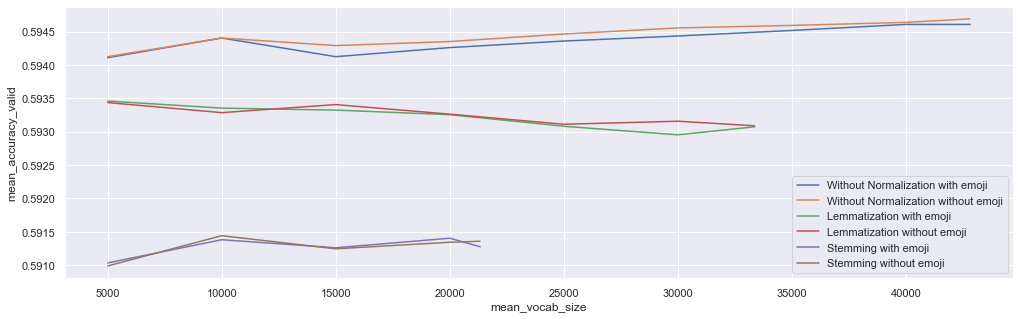

In [31]:
plt.figure(figsize=(17,5))
g00 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='none') & (results_5_tdidf.emoji=='w') & (results_5_tdidf.C==0.5)],
    label='Without Normalization with emoji'
)
g01 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='none') & (results_5_tdidf.emoji=='wo') & (results_5_tdidf.C==0.5)],
    label='Without Normalization without emoji'
)
g20 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='lemma') & (results_5_tdidf.emoji=='w') & (results_5_tdidf.C==0.25)],
    label='Lemmatization with emoji'
)
g21 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='lemma') & (results_5_tdidf.emoji=='wo') & (results_5_tdidf.C==0.25)],
    label='Lemmatization without emoji'
)
g10 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='stem') & (results_5_tdidf.emoji=='w') & (results_5_tdidf.C==0.25)],
    label='Stemming with emoji'
)
g11 = sns.lineplot(
    x='mean_vocab_size', y='mean_accuracy_valid',
    data=results_5_tdidf[(results_5_tdidf.norm_type=='stem') & (results_5_tdidf.emoji=='wo') & (results_5_tdidf.C==0.25)],
    label='Stemming without emoji'
)

plt.legend()
g0.set_ylabel('Validation Accuracy')
g1.set_xlabel('C');

plt.legend()
g0.set_xlabel('C')
g0.set_ylabel('Validation Accuracy')
g0.set_title('Vocab Size per Normalization Type (TF-iDF, with emojis, optimum C)', size=14);